In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path
import time
from scipy.io import wavfile
from scipy import signal

# df_train

In [3]:
def get_data(path):
    ''' Returns dataframe with columns: 'path', 'word'.'''
    datadir = Path(path)
    files = [(str(f), f.parts[-2]) for f in datadir.glob('**/*.wav')]
    df = pd.DataFrame(files, columns=['path', 'word'])
    
    return df

In [4]:
df_train = get_data('./input/train/')

print('df_train.shape:', df_train.shape)
df_train.head()

df_train.shape: (64727, 2)


,path,word
0,input\train\audio\bed\00176480_nohash_0.wav,bed
1,input\train\audio\bed\004ae714_nohash_0.wav,bed
2,input\train\audio\bed\004ae714_nohash_1.wav,bed
3,input\train\audio\bed\00f0204f_nohash_0.wav,bed
4,input\train\audio\bed\00f0204f_nohash_1.wav,bed


## Word counts

In [5]:
print(len(df_train['word'].unique()))
df_train['word'].unique()

31


array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero', '_background_noise_'],
      dtype=object)

In [7]:
df_train['word'].value_counts()

stop                  2380
yes                   2377
seven                 2377
zero                  2376
no                    2375
up                    2375
two                   2373
go                    2372
four                  2372
one                   2370
six                   2369
right                 2367
on                    2367
nine                  2364
down                  2359
five                  2357
off                   2357
three                 2356
left                  2353
eight                 2352
house                 1750
marvin                1746
dog                   1746
wow                   1745
happy                 1742
sheila                1734
cat                   1733
tree                  1733
bird                  1731
bed                   1713
_background_noise_       6
Name: word, dtype: int64

## Spectrogram

In [13]:
def get_specgrams(paths, nsamples=16000):
    '''
    Given list of paths, return specgrams.
    '''
    
    # read the wav files
    wavs = [wavfile.read(path)[1] for path in paths]

    # zero pad the shorter samples and cut off the long ones.
    data = [] 
    for wav in wavs:
        if wav.size < 16000:
            d = np.pad(wav, (nsamples - wav.size, 0), mode='constant')
        else:
            d = wav[0:nsamples]
        data.append(d)

    # get the specgram
    specgram = [signal.spectrogram(d, nperseg=256, noverlap=128)[2] for d in data]
    specgram = [s.reshape(129, 124, -1) for s in specgram]
    
    return specgram

(129, 124)
(129, 124)
(129, 124)
(129, 124)
(129, 124)
(129, 124)
(129, 124)
(129, 124)
(129, 124)


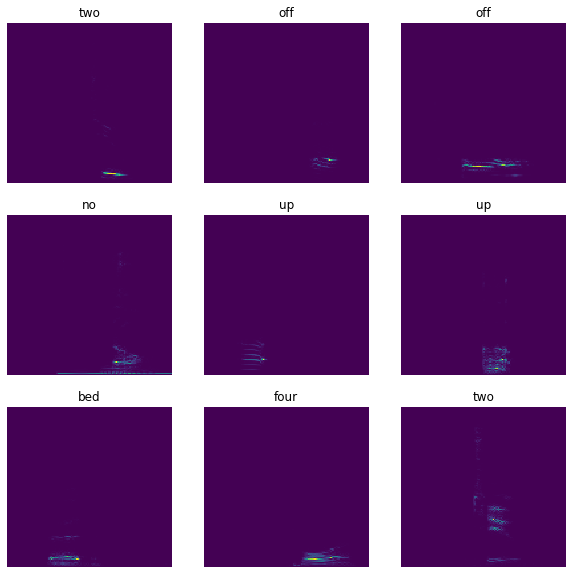

In [98]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(df_train['path'].sample(9, random_state=999)):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('\\')[-2]
    plt.title(label)

    # read the wav files
    sample_rate, wav  = wavfile.read(filepath)
    
    # zero pad the shorter samples and cut off the long ones.
    if wav.size < sample_rate:
        wav = np.pad(wav, (sample_rate - wav.size, 0), mode='constant')
    else:
        wav = wav[0:sample_rate]
    
    # create spectogram
    frequencies, times, spectrogram = signal.spectrogram(wav, fs=sample_rate, nperseg=256, noverlap=128)
    print(spectrogram.shape)
    
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.axis('off')

## Log spectrogram

In [121]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

(99, 161)
(99, 161)
(99, 161)
(99, 161)
(99, 161)
(99, 161)
(99, 161)
(99, 161)
(99, 161)


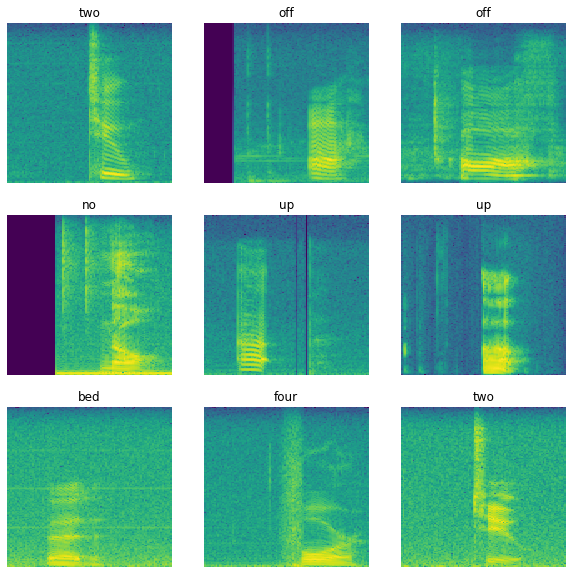

In [122]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(df_train['path'].sample(9, random_state=999)):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('\\')[-2]
    plt.title(label)
    
    # read the wav files
    sample_rate, wav  = wavfile.read(filepath)
    
    # zero pad the shorter samples and cut off the long ones.
    if wav.size < sample_rate:
        wav = np.pad(wav, (sample_rate - wav.size, 0), mode='constant')
    else:
        wav = wav[0:sample_rate]
    
    # create spectogram
    _, _, spectrogram = log_specgram(wav, sample_rate)
    print(spectrogram.shape)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

## Spectrogram vs Waveforms

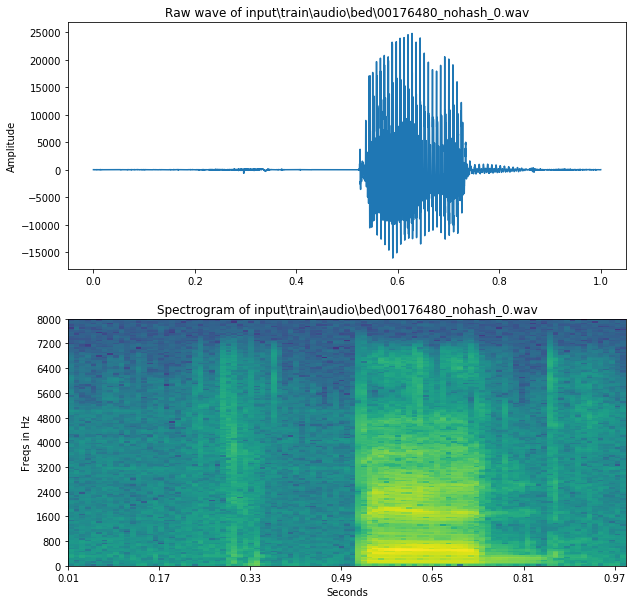

In [160]:
sample_rate, wav = wavfile.read(df_train['path'][0])
freqs, times, spectrogram = log_specgram(wav, sample_rate)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + df_train['path'][0])
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(wav), sample_rate), wav)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + df_train['path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
plt.show()

In [164]:
len(wav)

16000